In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch

In [ ]:
# !pip install keras_tuner

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv(r"/content/drive/MyDrive/Thesis_GoldPriceForecasting/Gold Price (2013-2022).csv")

In [ ]:
test = pd.read_csv(r"/content/drive/MyDrive/Thesis_GoldPriceForecasting/gold_price(2023).csv")

In [ ]:
train.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      257 non-null    object
 1   Price     257 non-null    object
 2   Open      257 non-null    object
 3   High      257 non-null    object
 4   Low       257 non-null    object
 5   Vol.      257 non-null    object
 6   Change %  257 non-null    object
dtypes: object(7)
memory usage: 14.2+ KB


# Preprocessing

In [ ]:
train['Vol.'].value_counts().head()    # We can see that the value type of this column is object, and they contain some kind of abbreviations (K)

,count
Vol.,
0.02K,48
0.01K,45
0.04K,42
0.03K,38
0.07K,33


In [ ]:
# Check invalid type in column Vol. in train dataset
train[train['Vol.'].apply(lambda x: isinstance(x, float))]

,Date,Price,Open,High,Low,Vol.,Change %
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
26,11/24/2022,"1,755.35","1,753.05","1,758.95","1,752.55",NaN,0.56%
84,09/05/2022,"1,724.80","1,719.20","1,726.60","1,718.75",NaN,0.36%
85,09/04/2022,"1,718.65","1,723.60","1,723.75","1,718.65",NaN,0.06%
2001,04/03/2015,"1,200.90","1,200.90","1,200.90","1,200.90",NaN,0.00%


In [ ]:
# Check invalid type in column Vol. in test dataset
test[test['Vol.'].apply(lambda x: isinstance(x, float))]

,Date,Price,Open,High,Low,Vol.,Change %


In [ ]:
# Fill in missing values with most frequent values
mode = train['Vol.'].mode()[0]
train['Vol.'] = train['Vol.'].fillna(mode)

In [ ]:
train['Change %'].value_counts().head()    # We can see that the value type of this column is object, and they contain some kind of abbreviations (%)

,count
Change %,
0.00%,29
0.04%,27
0.03%,25
-0.20%,24
-0.14%,23


In [ ]:
# Create a function to change the type of column into suitable type that can be used.
# Specifically, change different units of values in Vol. into numeric
# And remove % sign in Change column
def change_type(value):
  if isinstance(value, str):
    if 'K' in value:
      return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
      return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
      return float(value.replace('B', '').astype(float)) * 1e9
    elif '%' in value:
      return float(value.replace('%', ''))
    elif ',' in value:
      return float(value.replace(',', ''))
    else:
      return float(value)
  return value

In [ ]:
def preprocess(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Vol.'] = df['Vol.'].apply(lambda x: change_type(x))
  df['Change %'] = df['Change %'].apply(lambda x: change_type(x))
  df['Open'] = df['Open'].apply(lambda x: change_type(x))
  df['High'] = df['High'].apply(lambda x: change_type(x))
  df['Low'] = df['Low'].apply(lambda x: change_type(x))
  df['Price'] = df['Price'].apply(lambda x: change_type(x))
  df.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'}, inplace=True)
  df.sort_values(by = 'Date', ascending = True, inplace = True)
  df.set_index('Date', inplace=True)
  return df

In [ ]:
preprocessed_train = preprocess(train)
preprocessed_train.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2013-01-02,1689.9,1675.8,1695.0,1672.1,60.0,0.78
2013-01-03,1675.6,1688.0,1689.3,1664.3,190.0,-0.85
2013-01-04,1649.9,1664.4,1664.4,1630.0,310.0,-1.53
2013-01-07,1647.2,1657.3,1663.8,1645.3,90.0,-0.16
2013-01-08,1663.2,1651.5,1662.6,1648.8,130.0,0.97


In [ ]:
preprocessed_test = preprocess(test)
preprocessed_test.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2023-01-03,1846.1,1831.8,1856.6,1831.3,212270.0,1.09
2023-01-04,1859.0,1845.2,1871.3,1842.0,198350.0,0.70
2023-01-05,1840.6,1861.2,1864.3,1829.9,188600.0,-0.99
2023-01-06,1869.7,1835.9,1875.2,1835.2,215370.0,1.58
2023-01-09,1877.8,1872.8,1886.4,1869.3,204550.0,0.43


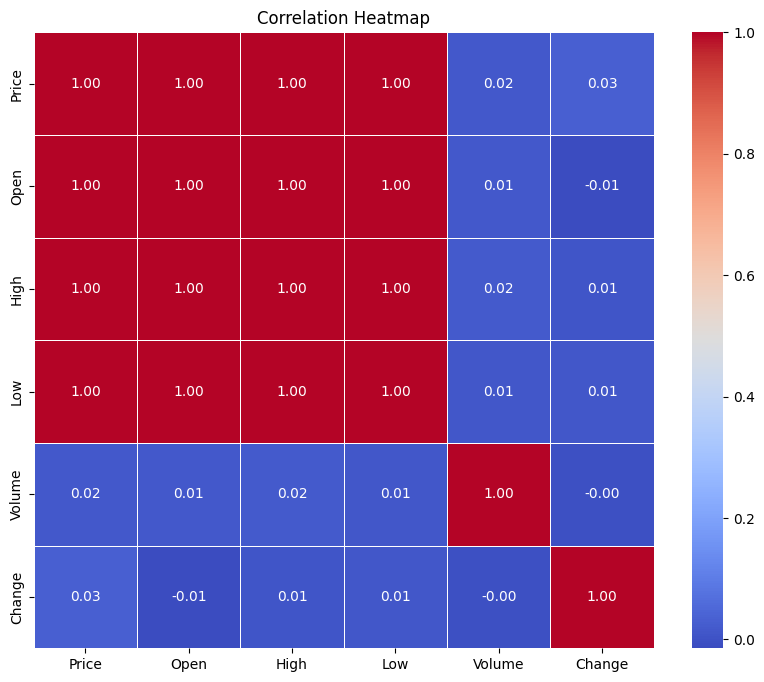

In [ ]:
# Compute correlation matrix including the target
corr_matrix = preprocessed_train.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

From the heatmap, it is clear that both columns with extremely high correlation with target (Low, High, Open) and columns with extremely low correlation with target (Volume, Change) have no predictive power or any impact an the target. Therefore, these columns will be removed before training.

# RNN Model

## Split and Scale the datasets

In [ ]:
n = len(train)
train_size = int(n * 0.8)

# Split the data
train = preprocessed_train.iloc[:train_size]
val = preprocessed_train.iloc[train_size:]

# MinMax scaling the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(preprocessed_test)


## Reshape the datasets into 3D

In [ ]:
window_size = 30   # many previous time steps you want to use to predict the next one. For each prediction, you'll look back at the last 30 time steps / 1 month.
X_train_3d = []
y_train_3d = []

X_val_3d = []
y_val_3d = []

X_test_3d = []
y_test_3d = []
for i in range(window_size, len(scaled_train)):
    X_train_3d.append(scaled_train[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_train_3d.append(scaled_train[i, 0]) #  grabs the actual value at time i

for i in range(window_size, len(scaled_test)):
    X_val_3d.append(scaled_val[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_val_3d.append(scaled_val[i, 0]) #  grabs the actual value at time i

for i in range(window_size, len(scaled_test)):
    X_test_3d.append(scaled_test[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_test_3d.append(scaled_test[i, 0]) #  grabs the actual value at time i

# Turn the data into numpy array
X_train_3d = np.array(X_train_3d)
y_train = np.array(y_train_3d)
X_val_3d = np.array(X_val_3d)
y_val = np.array(y_val_3d)
X_test_3d = np.array(X_test_3d)
y_test = np.array(y_test_3d)


# Reshape the data into 3d
X_train = X_train_3d.reshape((X_train_3d.shape[0], X_train_3d.shape[1], 1))
X_val = X_val_3d.reshape((X_val_3d.shape[0], X_val_3d.shape[1], 1))
X_test = X_test_3d.reshape((X_test_3d.shape[0], X_test_3d.shape[1], 1))



# Creating the RNN model

## Hyperparameter Tuning

In [ ]:
# The model consists of two LSTM layers and drop out layer after each to prevent overfitting
# The model concludes with a Dense layer to predict a single value
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return model
# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='time_series',
    overwrite=True

)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 23s]
val_loss: 0.12281886488199234

Best val_loss So Far: 0.0003624632954597473
Total elapsed time: 00h 06m 08s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 192)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,361 (435.00 KB)

 Trainable params: 111,361 (435.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# The best number of units for each layer of the model
for layer in best_model.layers:
    if hasattr(layer, 'units'):
        print(f"{layer.name} has {layer.units} units")

simple_rnn has 192 units
simple_rnn_1 has 192 units
dense has 1 units


In [ ]:
# The best learning rate of the model
learning_rate = best_model.optimizer.learning_rate.numpy()
print(f"Learning rate: {learning_rate}")

Learning rate: 0.0010000000474974513


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Train and predict
predictions = best_model.predict(X_test)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
# R-squared (R²) Score
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
MSE: 0.0004
RMSE: 0.0202
MAE: 0.0156
R²: 0.8839


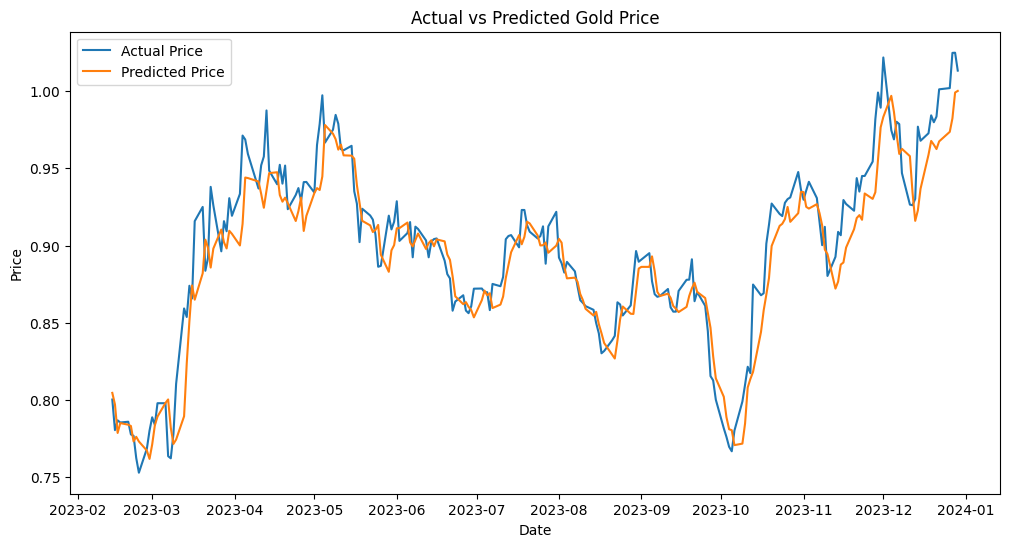

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[window_size:], y_test, label='Actual Price')
plt.plot(test.index[window_size:], predictions, label='Predicted Price')
plt.title('Actual vs Predicted Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()